In [87]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import factorial, gammaincc, gamma
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.special import gamma, gammainc
import h5py
from scipy.optimize import curve_fit
import sys

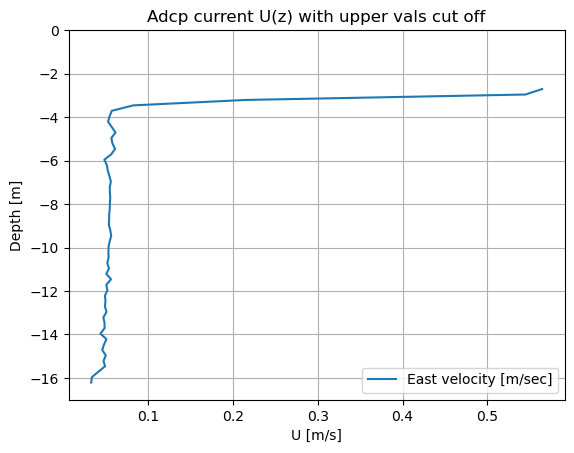

In [88]:
hf = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\ADCP_19_01_22_04.mat', 'r')
east_vel = np.array(hf['East_vel'])
north_vel = np.array(hf['North_vel'])
vertical_vel = np.array(hf['Vertical_vel'])
z_adcp = np.array(hf['z_vec'])[:55]
t = hf['time_vec']
hf.close()

time_start = 0*60 # sec
time_stop = 15*60 # sec
time_step = 1 #sec
start_i = int(time_start/time_step)
stop_i = int(time_stop/time_step)

east_vel_mean = np.mean(east_vel[start_i:stop_i], axis=0)[:55]
north_vel_mean = np.mean(north_vel[start_i:stop_i], axis=0)
vertical_vel_mean = np.mean(vertical_vel[start_i:stop_i], axis=0)

fig, ax = plt.subplots()
ax.plot(east_vel_mean, z_adcp, label='East velocity [m/sec]')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,0)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) with upper vals cut off")
plt.show()

# 1) Find Doppler Shifts 

## 1.1) U(z)

### 1.1) Continuous straight line

In [89]:
no = np.argmax(east_vel_mean)

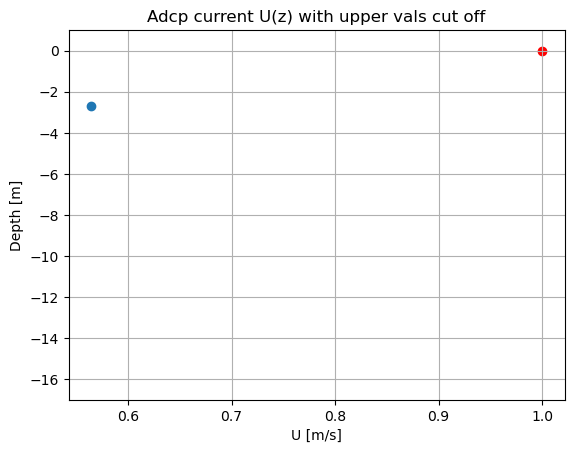

In [90]:
plt.scatter(east_vel_mean[no], z_adcp[no], label='East velocity [m/sec]')

plt.scatter(1, 0, color = 'red', label = 'maximum point assumption')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,1)
#plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) with upper vals cut off")
plt.show()

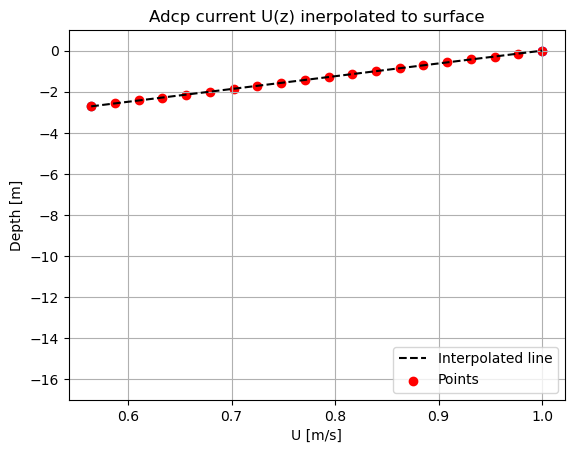

In [91]:
# Define the number of points you want to interpolate
num_points = 20  # Adjust this as needed

# Interpolate the points
x_line = np.linspace(east_vel_mean[no], 1, num_points)
y_line = np.linspace(z_adcp[no], 0, num_points)

# Plot the scatter plot of the data points
plt.scatter(east_vel_mean[no], z_adcp[no])
plt.scatter(1, 0, color='blue')

# Interpolate a straight line between the points
plt.plot(x_line, y_line, 'k--', label='Interpolated line')

# Plot the equally spaced points
plt.scatter(x_line, y_line, color='red', label='Points')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 1)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) inerpolated to surface")
plt.show()


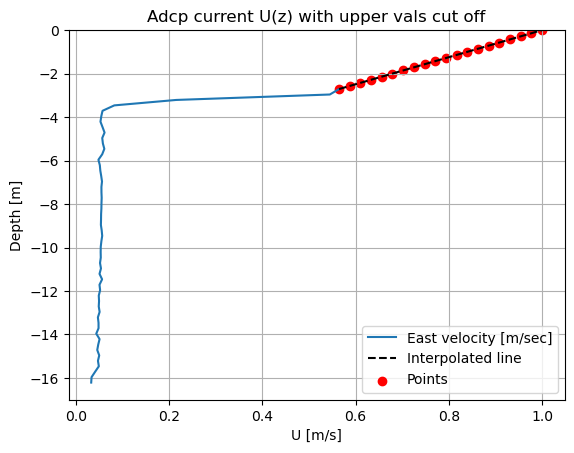

In [92]:
plt.plot(east_vel_mean, z_adcp, label='East velocity [m/sec]')

# Interpolate a straight line between the points
plt.plot(x_line, y_line, 'k--', label='Interpolated line')

# Plot the equally spaced points
plt.scatter(x_line, y_line, color='red', label='Points')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,0)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) with upper vals cut off")
plt.show()

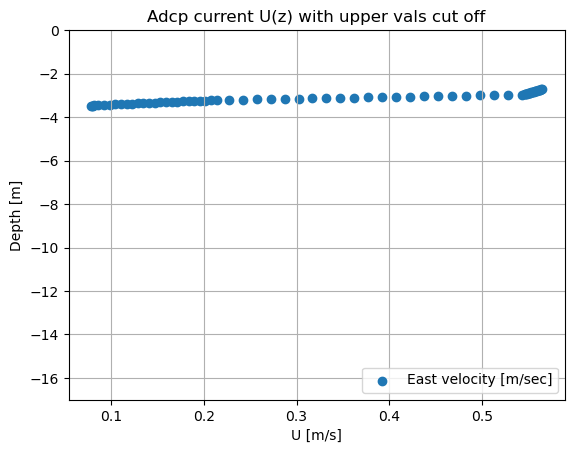

In [93]:
# Interpolate tto get more shear values
z_interpolated = np.linspace(-3.5, max(z_adcp), 70)
east_vel_interpolated = np.interp(z_interpolated, z_adcp.flatten(), east_vel_mean)

# Plot the interpolated data
plt.scatter(east_vel_interpolated, z_interpolated, label='East velocity [m/sec]')
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 0)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Adcp current U(z) with upper vals cut off")

plt.show()

In [94]:
#new_interpolated_z = np.concatenate((z_adcp.flatten(),y_line.flatten(), z_interpolated.flatten()))
#new_interpolated_U = np.concatenate((east_vel_mean, x_line, east_vel_interpolated.flatten()))

new_interpolated_z = np.concatenate((z_adcp.flatten(), z_interpolated.flatten(),y_line.flatten()))
new_interpolated_U = np.concatenate((east_vel_mean, east_vel_interpolated.flatten(), x_line))


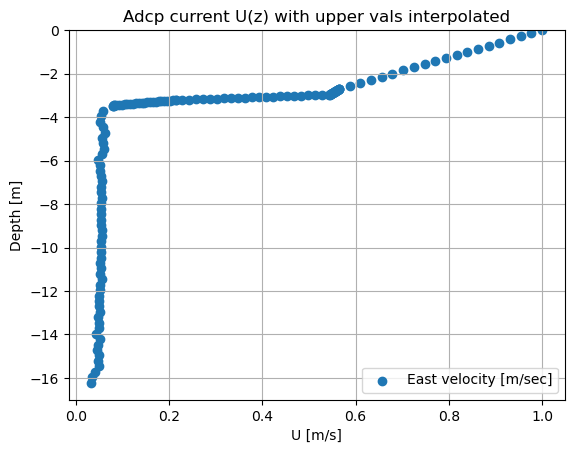

In [95]:
# Plot the interpolated data
plt.scatter(new_interpolated_U, new_interpolated_z, label='East velocity [m/sec]')
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 0)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Adcp current U(z) with upper vals interpolated")

plt.show()

In [96]:
stew_joy_interp = []
k_1 = np.linspace(0.01, 0.35, 40)

for i in range(len(k_1)):
    integral = 2 * k_1[i] * np.trapz(new_interpolated_U *np.e**(2*k_1[i]*new_interpolated_z), x=new_interpolated_z)
    stew_joy_interp.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_ineterp_array = np.array(stew_joy_interp)

Text(0.5, 1.0, 'Doppler shifts from ADCP')

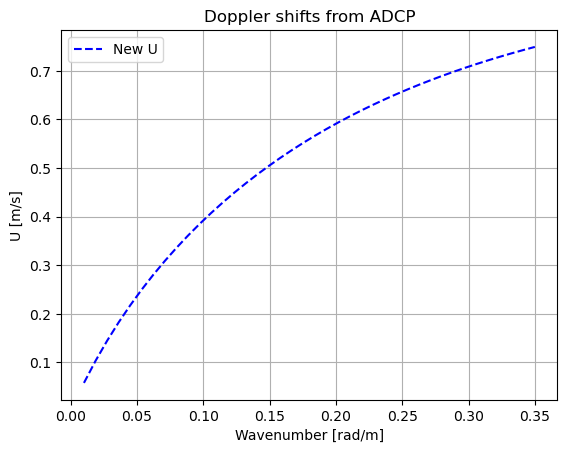

In [97]:
plt.plot(k_1, stew_joy_ineterp_array, label = 'New U', linestyle='--', color='blue')
#plt.plot(orig_k, orig_U, label = 'Correct U - original fitting', linestyle='-', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("Doppler shifts from ADCP")

#plt.ylim(0,0.6)

In [98]:
pPEDM_1, pEDM_1, eps_PEDM_1, eps_EDM_1, verbose_1 = pedm(k_1, stew_joy_ineterp_array)

In [99]:
z = np.linspace(-16, 0, 100)
U_1_fun = lambda z: np.polyval(pPEDM_1, z)

(-16.0, 0.0)

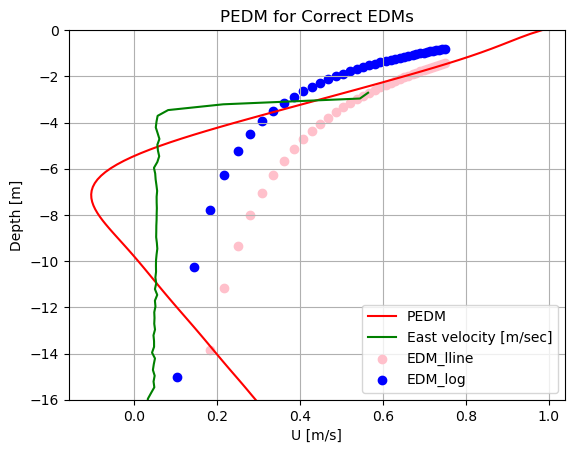

In [101]:
plt.plot(U_1_fun(z), z, label="PEDM", color = 'red')
plt.plot(east_vel_mean, z_adcp, label='East velocity [m/sec]', color= 'g')

#plt.scatter( c_dop, -1/(3.56*wave_no), label='EDM_line', color = 'blue')
plt.scatter( stew_joy_ineterp_array, -1/(2*k_1), label='EDM_lline', color = 'pink')
plt.scatter( stew_joy_ineterp_array, -1/(3.56*k_1), label='EDM_log', color = 'blue')


plt.grid(True)
plt.title("PEDM for Correct EDMs")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
plt.ylim(-16,0)

# 1.1.2) Straight up line

In [48]:
no = np.argmax(east_vel_mean)

In [239]:
point = (east_vel_mean[no]+0.4, 0)

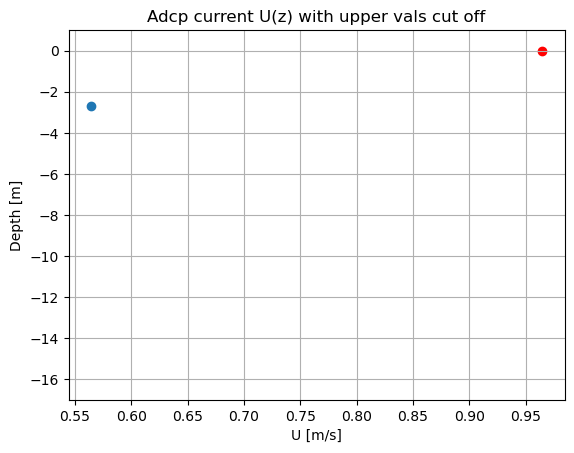

In [240]:
plt.scatter(east_vel_mean[no], z_adcp[no], label='East velocity [m/sec]')

plt.scatter(point[0], point[1], color = 'red', label = 'maximum point assumption')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,1)
#plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) with upper vals cut off")
plt.show()

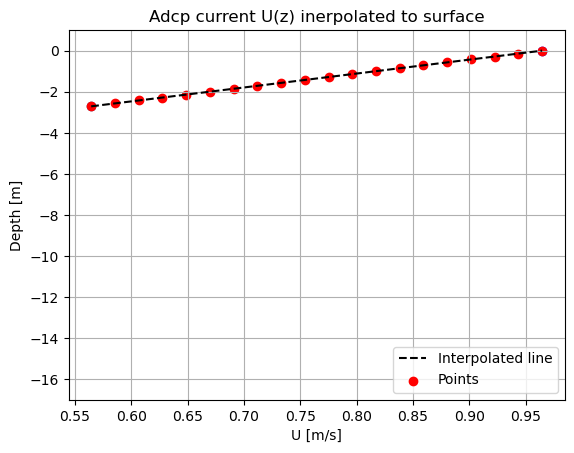

In [241]:
# Define the number of points you want to interpolate
num_points = 20  # Adjust this as needed

# Interpolate the points
x_line = np.linspace(east_vel_mean[no], point[0], num_points)
y_line = np.linspace(z_adcp[no], point[1], num_points)

# Plot the scatter plot of the data points
plt.scatter(east_vel_mean[no], z_adcp[no])
plt.scatter(point[0], point[1], color='blue')

# Interpolate a straight line between the points
plt.plot(x_line, y_line, 'k--', label='Interpolated line')

# Plot the equally spaced points
plt.scatter(x_line, y_line, color='red', label='Points')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 1)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) inerpolated to surface")
plt.show()

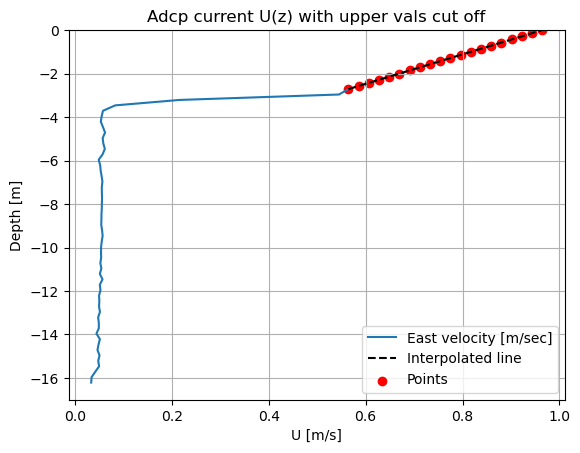

In [242]:
plt.plot(east_vel_mean, z_adcp, label='East velocity [m/sec]')

# Interpolate a straight line between the points
plt.plot(x_line, y_line, 'k--', label='Interpolated line')

# Plot the equally spaced points
plt.scatter(x_line, y_line, color='red', label='Points')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,0)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) with upper vals cut off")
plt.show()

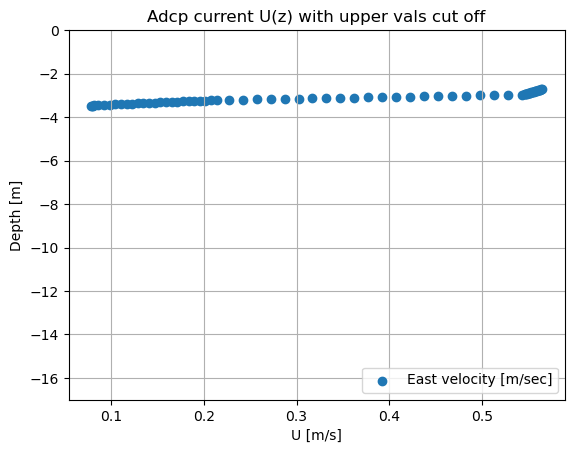

In [243]:
# Interpolate tto get more shear values
z_interpolated = np.linspace(-3.5, max(z_adcp), 70)
east_vel_interpolated = np.interp(z_interpolated, z_adcp.flatten(), east_vel_mean)

# Plot the interpolated data
plt.scatter(east_vel_interpolated, z_interpolated, label='East velocity [m/sec]')
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 0)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Adcp current U(z) with upper vals cut off")

plt.show()

In [244]:
new_interpolated_z = np.concatenate((z_adcp.flatten(), z_interpolated.flatten(),y_line.flatten()))
new_interpolated_U = np.concatenate((east_vel_mean, east_vel_interpolated.flatten(), x_line))


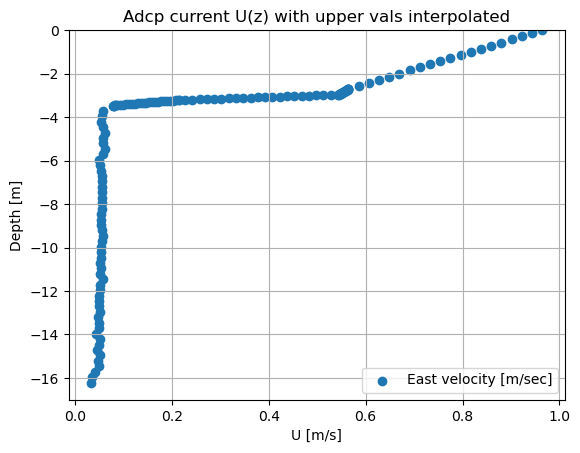

In [245]:
# Plot the interpolated data
plt.scatter(new_interpolated_U, new_interpolated_z, label='East velocity [m/sec]')
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 0)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Adcp current U(z) with upper vals interpolated")

plt.show()

In [259]:
stew_joy_interp_1 = []
k_1 = np.linspace(0.01, 0.2, 40)

for i in range(len(k_1)):
    integral = 2 * k_1[i] * np.trapz(new_interpolated_U *np.e**(2*k_1[i]*new_interpolated_z), x=new_interpolated_z)
    stew_joy_interp_1.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_ineterp_array_1 = np.array(stew_joy_interp_1)

Text(0.5, 1.0, 'Doppler shifts from ADCP')

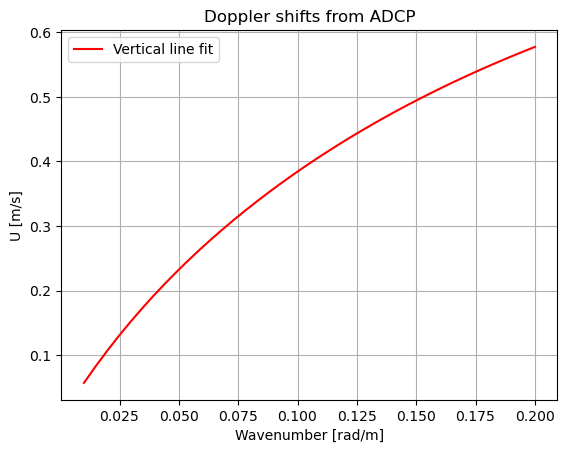

In [260]:
#plt.plot(k_1, stew_joy_ineterp_array, label = 'interpolated line fit', linestyle='--', color='blue')
plt.plot(k_1, stew_joy_ineterp_array_1, label = 'Vertical line fit', linestyle='-', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("Doppler shifts from ADCP")


In [270]:
pPEDM_1, pEDM_1, eps_PEDM_1, eps_EDM_1, verbose_1 = pedm(k_1, stew_joy_ineterp_array_1)
z = np.linspace(-16, 0, 100)
U_1_fun = lambda z: np.polyval(pPEDM_1, z)


(-16.0, 0.0)

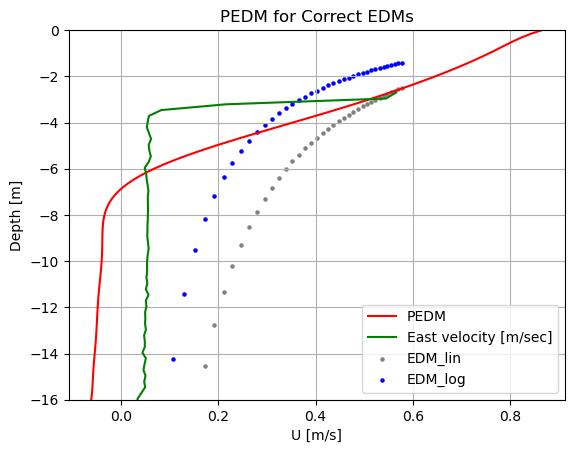

In [271]:
plt.plot(U_1_fun(z), z, label="PEDM", color = 'red')
plt.plot(east_vel_mean, z_adcp, label='East velocity [m/sec]', color= 'g')

#plt.scatter( c_dop, -1/(3.56*wave_no), label='EDM_line', color = 'blue')
plt.scatter( stew_joy_ineterp_array_1, -1/(2*k_1), label='EDM_lin', color = 'grey', s = 5)
plt.scatter( stew_joy_ineterp_array_1, -1/(3.56*k_1), label='EDM_log', color = 'blue', s = 5)


plt.grid(True)
plt.title("PEDM for Correct EDMs")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
plt.ylim(-16,0)

## 1.2) Shear Current

In [47]:
U_const = np.mean(east_vel_mean[:50])
U_const

0.05182963

In [19]:
U_shear = east_vel_mean - U_const

Text(0.5, 1.0, 'Shear Current U_shear')

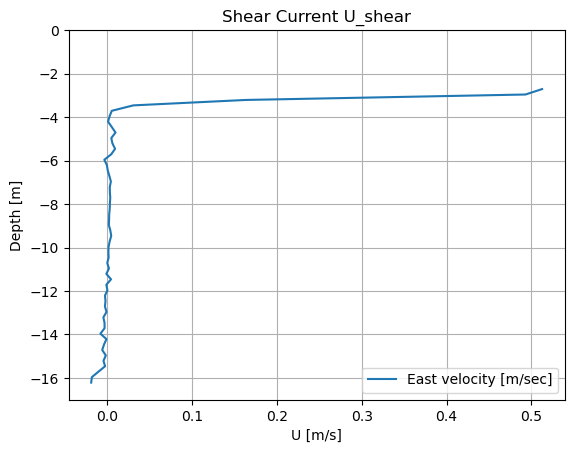

In [20]:
plt.plot(U_shear, z_adcp, label='East velocity [m/sec]')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,0)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Shear Current U_shear")

In [21]:
z_adcp_1d = z_adcp.ravel()

In [22]:
stew_joy = []
k_1 = np.linspace(0.01, 0.35, 30)

for i in range(len(k_1)):
    integral = 2 * k_1[i] * np.trapz(U_shear *np.e**(2*k_1[i]*z_adcp_1d), x=z_adcp_1d)
    stew_joy.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_array = np.array(stew_joy)

In [23]:
2 * 0.3 * np.trapz(U_shear *np.e**(2*0.3*z_adcp_1d), x=z_adcp_1d)

0.024690027486448263

(0.0, 0.6)

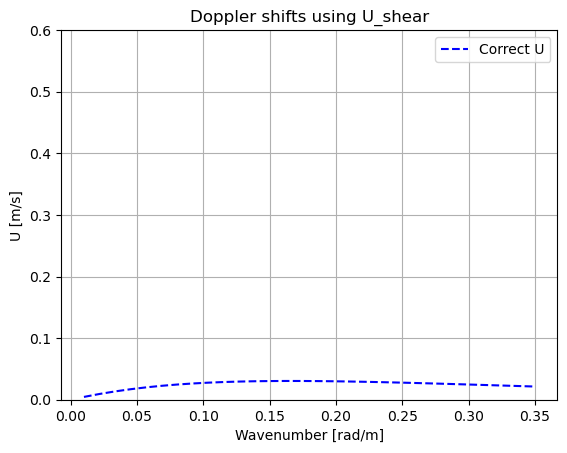

In [24]:
plt.plot(k_1, stew_joy_array, label = 'Correct U', linestyle='--', color='blue')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("Doppler shifts using U_shear")

plt.ylim(0,0.6)

In [269]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=16):

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if len(k_vect) == 0 or len(c_til) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2 Effect of limitations of measured Doppler shifts
    # Define the parameters.
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1

                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

In [25]:
pPEDM_1, pEDM_1, eps_PEDM_1, eps_EDM_1, verbose_1 = pedm(k_1, stew_joy_array)

In [132]:
z = np.linspace(-16, 0, 100)
U_1_fun = lambda z: np.polyval(pPEDM_1, z)

(-16.0, 0.0)

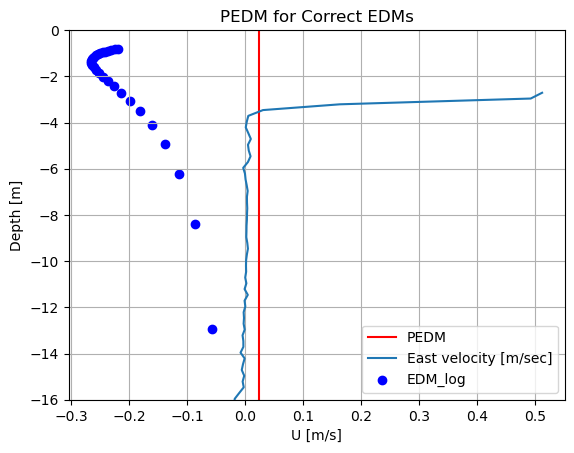

In [135]:
plt.plot(U_1_fun(z), z, label="PEDM", color = 'red')
#plt.plot(U,z, label='U values', color='green')
#plt.plot(U_shear,z, label='U_shear', color='black')

plt.plot(U_shear, z_adcp, label='East velocity [m/sec]')



#plt.scatter( c_dop, -1/(3.56*wave_no), label='EDM_line', color = 'blue')
#plt.scatter( stew_joy_array, -1/(2*k_1), label='EDM_log', color = 'blue')
plt.scatter( stew_joy_array, -1/(3.56*k_1), label='EDM_log', color = 'blue')


plt.grid(True)
plt.title("PEDM for Correct EDMs")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
plt.ylim(-16,0)

Text(0.5, 1.0, 'Adcp current U(z) with upper vals cut off')

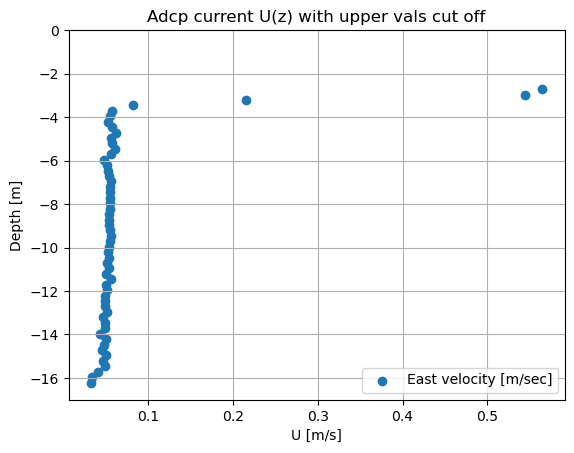

In [136]:
plt.scatter(east_vel_mean, z_adcp, label='East velocity [m/sec]')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,0)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) with upper vals cut off")

In [242]:
stew_joy = []
k_1 = np.linspace(0.01, 0.35, 30)

for i in range(len(k_1)):
    integral = 2 * k_1[i] * np.trapz(east_vel_mean *np.e**(2*k_1[i]*z_adcp.flatten()), x = z_adcp.flatten())
    stew_joy.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_array = np.array(stew_joy)

In [243]:
np.max(stew_joy_array)

0.05543734237654653

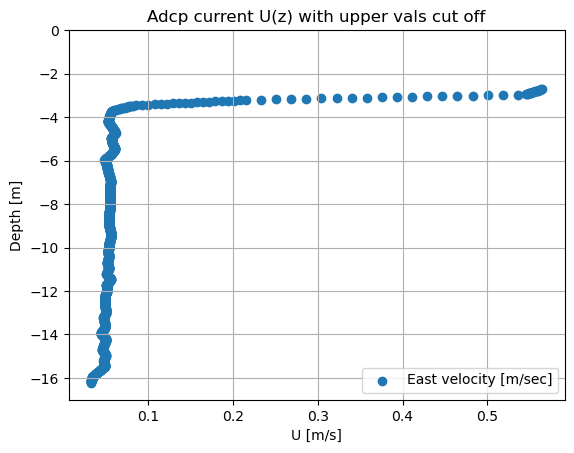

In [244]:
# Interpolate to get 100 points
z_interpolated = np.linspace(min(z_adcp), max(z_adcp), 1000)
east_vel_interpolated = np.interp(z_interpolated, z_adcp.flatten(), east_vel_mean)

# Plot the interpolated data
plt.scatter(east_vel_interpolated, z_interpolated, label='East velocity [m/sec]')
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 0)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Adcp current U(z) with upper vals cut off")

plt.show()


In [245]:
stew_joy = []
k_1 = np.linspace(0.01, 0.35, 30)

for i in range(len(k_1)):
    integral = 2 * k_1[i] * np.trapz(east_vel_interpolated.flatten() *np.e**(2*k_1[i]*z_interpolated.flatten()), x = z_interpolated.flatten())
    stew_joy.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_array = np.array(stew_joy)

In [246]:
velocity = east_vel_interpolated.flatten()[::4]

In [247]:
zs = z_interpolated.flatten()[::4]

In [195]:
velocity = np.array([0.03300297, 0.04966653002934024, 0.04872703247449615, 0.05184188, 0.07567891, 0.11878413,
       0.19118959, 0.33512298, 0.51482033, 0.55370443, 0.56442589, 0.097232  , 0.12120572, 0.14517943, 0.16915315, 0.19312686,
       0.21973204, 0.27923049, 0.33872894, 0.3982274 , 0.45772585,
       0.5172243 , 0.54667632, 0.55022623, 0.55377615, 0.55732606,
       0.56087597, 0.56442589, 0.05114462, 0.05159113, 0.05259842, 0.05342255, 0.05387098,
       0.05651096, 0.05398241, 0.05419223, 0.05495824, 0.05531866,
       0.05508177, 0.05460813, 0.0517802 , 0.05285981, 0.06008314, 0.05839449, 0.0574697 , 0.05674781, 0.05924254,
       0.0614292 , 0.05907826, 0.05671377, 0.05430933, 0.05327557,
       0.05423554, 0.03300297, 0.03371067, 0.04000182, 0.04707945, 0.04822451,
       0.04889487, 0.0484429 , 0.0466686 , 0.04875296, 0.05005381,
       0.04402397, 0.04844074, 0.04873031, 0.04771441, 0.0497315 ,
       0.05004187, 0.12922095, 0.14357159, 0.15792222, 0.17227285, 0.18662348,
       0.20097411, 0.21532474, 0.25094044, 0.28655613, 0.32217182,
       0.35778751, 0.3934032 , 0.42901889, 0.46463458, 0.50025027,
       0.53586596, 0.54636361, 0.54848859, 0.55061356, 0.55273853,
       0.55486351, 0.55698848, 0.55911345, 0.56123843, 0.5633634])

zs = np.array([-16.21156185, -14.166107301773147, -13.484289119954965, -11.984289119954965, -3.52974367,  -3.39338003,  -3.25701639,
        -3.12065276,  -2.98428912,  -2.84792548,  -2.71156185, -3.43396987, -3.38881937, -3.34366887, -3.29851837, -3.25336787,
       -3.20821737, -3.16306686, -3.11791636, -3.07276586, -3.02761536,
       -2.98246486, -2.93731436, -2.89216385, -2.84701335, -2.80186285,
       -2.75671235, -2.71156185, -11.69651168, -11.24500666, -10.79350165, -10.34199663,
        -9.89049161,  -9.4389866 ,  -8.98748158,  -8.53597656,
        -8.08447155,  -7.63296653,  -7.18146151,  -6.7299565 ,
        -6.27845148,  -5.82694646, -5.37544145, -5.23998994, -5.10453844, -4.96908693, -4.83363543,
       -4.69818392, -4.56273242, -4.42728091, -4.29182941, -4.1563779 ,
       -4.0209264, -16.21156185, -15.98580934, -15.76005683, -15.53430432,
       -15.30855181, -15.08279931, -14.8570468 , -14.63129429,
       -14.40554178, -14.17978927, -13.95403676, -13.72828426,
       -13.50253175, -13.27677924, -13.05102673, -12.82527422, -3.37372401, -3.34669698, -3.31966996, -3.29264293, -3.2656159 ,
       -3.23858887, -3.21156185, -3.18453482, -3.15750779, -3.13048077,
       -3.10345374, -3.07642671, -3.04939969, -3.02237266, -2.99534563,
       -2.9683186 , -2.94129158, -2.91426455, -2.88723752, -2.8602105 ,
       -2.83318347, -2.80615644, -2.77912941, -2.75210239, -2.72507536])

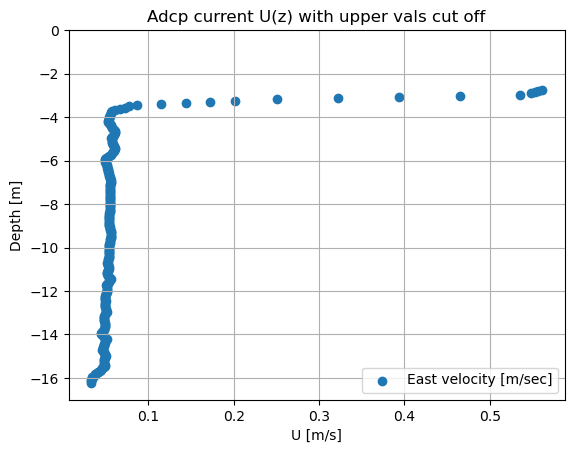

In [248]:
# Plot the interpolated data
plt.scatter(velocity, zs, label='East velocity [m/sec]')
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 0)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Adcp current U(z) with upper vals cut off")

plt.show()

In [249]:
stew_joy = []
k_1 = np.linspace(0.01, 0.35, 30)

for i in range(len(k_1)):
    integral = 2 * k_1[i] * np.trapz(velocity *np.e**(2*k_1[i]*zs), x = zs)
    stew_joy.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_array = np.array(stew_joy)

In [250]:
stew_joy_array

array([0.01575247, 0.02889782, 0.03791455, 0.04400473, 0.04800847,
       0.0505153 , 0.05194093, 0.05258023, 0.05264382, 0.05228338,
       0.0516092 , 0.05070231, 0.04962296, 0.04841651, 0.04711757,
       0.04575288, 0.04434339, 0.04290567, 0.041453  , 0.03999611,
       0.0385437 , 0.0371029 , 0.03567952, 0.03427834, 0.03290323,
       0.03155736, 0.03024324, 0.02896287, 0.02771779, 0.02650913])

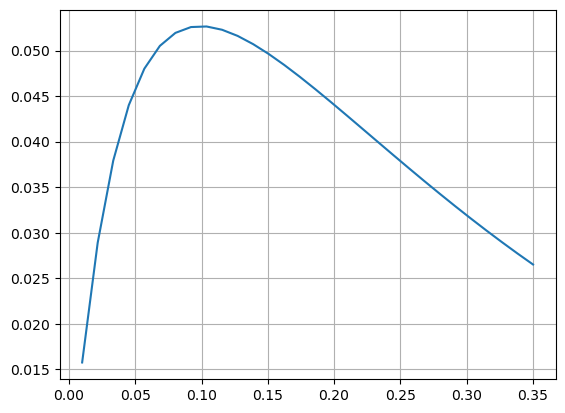

In [251]:
plt.plot(k_1, np.abs(stew_joy_array))

plt.grid(True)

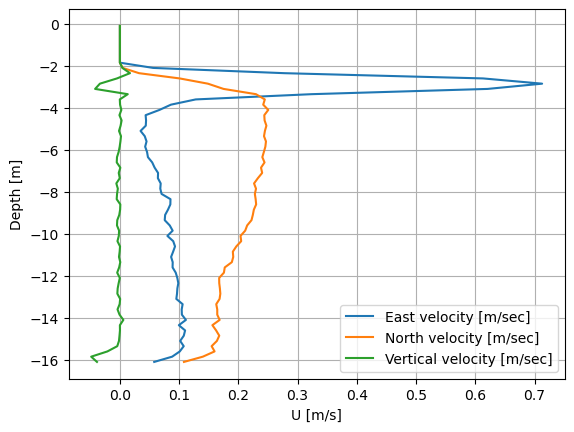

In [211]:
hf = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\ADCP_collection\ADCP_2022011821.mat', 'r')
east_vel = np.array(hf['East_vel'])
north_vel = np.array(hf['North_vel'])
vertical_vel = np.array(hf['Vertical_vel'])
z = np.array(hf['z_vec'])
t = hf['time_vec']
hf.close()

time_start = 0*60 # sec
time_stop = 3*60 # sec
time_step = 1 #sec
start_i = int(time_start/time_step)
stop_i = int(time_stop/time_step)

east_vel_mean = np.mean(east_vel[start_i:stop_i], axis=0)
north_vel_mean = np.mean(north_vel[start_i:stop_i], axis=0)
vertical_vel_mean = np.mean(vertical_vel[start_i:stop_i], axis=0)

fig, ax = plt.subplots()
ax.plot(east_vel_mean, z, label='East velocity [m/sec]')
ax.plot(north_vel_mean, z, label='North velocity [m/sec]')
ax.plot(vertical_vel_mean, z, label='Vertical velocity [m/sec]')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
def u_z(z):
    return np.e**(0.5*z) + 0.3

In [7]:
z = np.linspace(0, -20, 100)

In [8]:
def u1_z(z):
    return np.e**(0.2*z) + 0.3

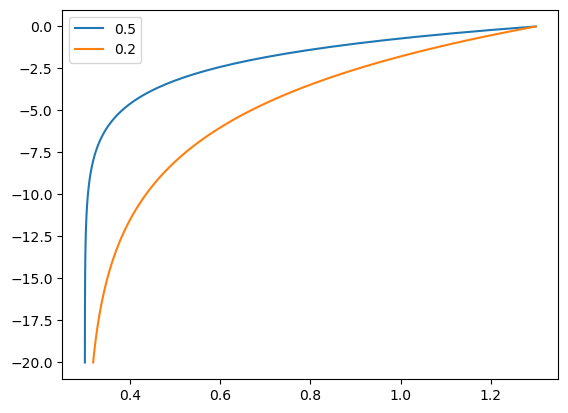

In [9]:
plt.plot( u_z(z), z, label = "0.5")
plt.plot( u1_z(z), z, label = "0.2")

plt.legend()